In [3]:
import os
os.chdir('/home/jovyan/signal-extraction/')

In [5]:
from simulator_code.Wavelet import *

In [36]:
# Load
signal = pd.read_csv('results/ERA5_norm_vae/ERA5_norm_vae_extractr_results_latent_full.csv')

# Ensure datetime index (and sorted)
signal['time'] = pd.to_datetime(signal['time'], errors='coerce')
signal = signal.set_index('time').sort_index()

# Make sure 'latent' is numeric
signal['mu'] = pd.to_numeric(signal['mu'], errors='coerce')

# --- Shift to ensure positivity ---
latent_min = signal['mu'].min()
if latent_min <= 0:
    eps = 1e-6  # nominal epsilon for numerical stability
    shift_value = -latent_min + eps
    signal['mu'] = signal['mu'] + shift_value
    print(f"Shifted latent values upward by {shift_value:.6f} to ensure positivity.")

# Signal date window
sig_start = signal.index.min()
sig_end   = signal.index.max()

# Annual maxima (calendar year-end). 'Y' or 'A-DEC' is equivalent to 'YE' here.
latent_annual_max = signal['mu'].resample('YE').mean()

# Years (from the index, not the values)
latent_years = signal.index.year
latent_time = np.unique(latent_years)

# Series of annual maxima values
latent_time_series = latent_annual_max.values

Shifted latent values upward by 0.003346 to ensure positivity.


In [33]:
siglvl_wave = 0.95
sigtest = 'default'

In [37]:
# wavelet transform
#warnings.filterwarnings('ignore', 'divide by zero encountered in divide', RuntimeWarning)
wlt = wavelet(latent_time_series)
Cw = CI(wlt, latent_time_series, siglvl_wave, "r")
C = CI(wlt, latent_time_series, siglvl_wave, "w")

# Global Wavelet Spectrum
plt_dataset = {
    'Time': latent_time,
    'Period': wlt['period'],
    'Avg_Power': wlt['avg_power'],
    'Power': wlt['power'],
    'COI': wlt['coi'],
    'W_noise': C['sig'],
    'R_noise': Cw['sig']
}

Red Noise AR1 Coefficient: 0.9528495292659217


/home/jovyan/signal-extraction/simulator_code/Wavelet.py:50: RuntimeWarning: divide by zero encountered in divide
  expnt = -(scl * k - param) ** 2 / (2 * (k > 0))
/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


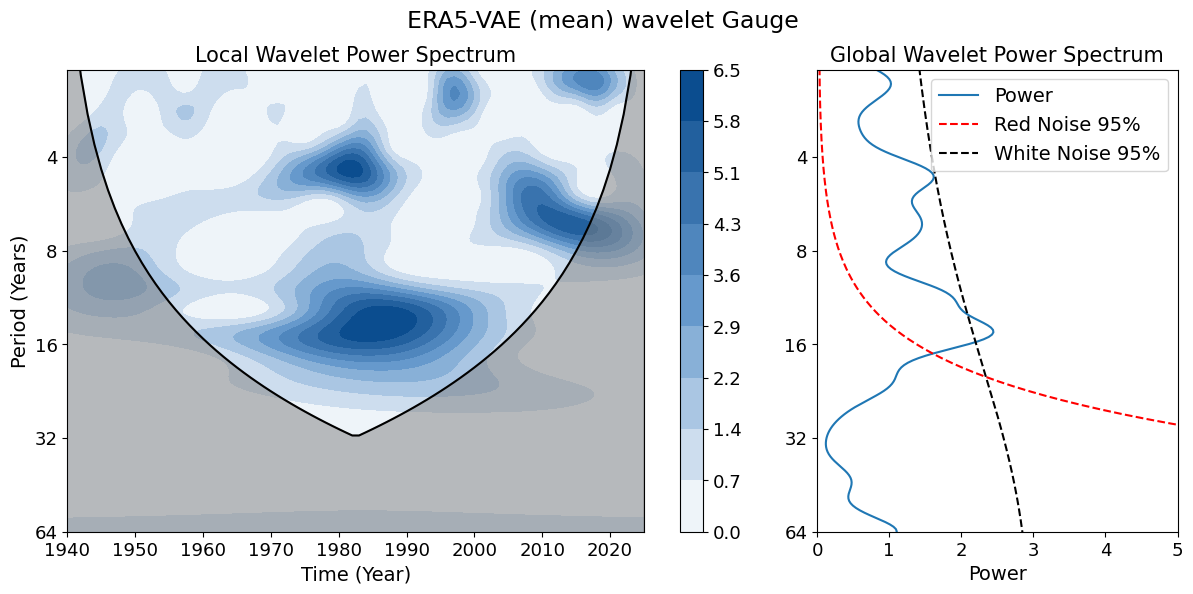

In [38]:
wavelet_plot(plt_dataset, siglvl_wave, "ERA5-VAE (mean) wavelet", sigtest)